# Proyecto End-to-End de analítica de clientes: Riesgo, Valor y Segmentación

Este proyecto aborda de forma integral distintos retos asociados a la analítica de clientes dentro del ámbito del marketing y la gestión de la relación con el cliente.

En primer lugar, se desarrolla un pipeline completo para la predicción del abandono, con el objetivo de anticipar la pérdida de clientes y facilitar estrategias de retención basadas en datos.

En segundo lugar, se construye un modelo orientado a estimar el valor potencial o coste de vida del cliente, permitiendo evaluar su rentabilidad esperada y priorizar recursos de forma más eficiente.

Finalmente, se aplican técnicas de aprendizaje no supervisado para segmentar la base de clientes en grupos homogéneos, facilitando la definición de estrategias comerciales diferenciadas.

En conjunto, el proyecto integra clasificación, regresión y clustering dentro de un mismo marco analítico, demostrando cómo distintas técnicas de machine learning pueden complementarse para apoyar decisiones estratégicas de negocio.

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [10]:
df_clv = pd.read_csv('data/clv/Marketing-Customer-Value-Analysis.csv', index_col=0)

df_clv.head()

,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,Location Code,...,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
Customer,,,,,,,,,,,,,,,,,,,,,
BU79786,Washington,2763.519279,No,Basic,Bachelor,2/24/11,Employed,F,56274,Suburban,...,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
QZ44356,Arizona,6979.535903,No,Extended,Bachelor,1/31/11,Unemployed,F,0,Suburban,...,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
AI49188,Nevada,12887.431650,No,Premium,Bachelor,2/19/11,Employed,F,48767,Suburban,...,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize
WW63253,California,7645.861827,No,Basic,Bachelor,1/20/11,Unemployed,M,0,Suburban,...,65,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize
HB64268,Washington,2813.692575,No,Basic,Bachelor,2/3/11,Employed,M,43836,Rural,...,44,0,1,Personal Auto,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize


Como en el caso anterior, vamos a dividir nuestras variables en númericas y categóricas para tratarlas de manera diferente:

In [22]:
dis_df_cols = df_clv.select_dtypes(exclude=np.number).columns.to_list()
num_df_cols = df_clv.select_dtypes(include=np.number).columns.to_list()

Comenzando por las columnas que contienen valores discretos, igual que anteriormente, conviene ver el número de valores que toma cada una

In [25]:
values_dis_df_col = list(map(lambda col: (col,len(df_clv[col].value_counts())), dis_df_cols))
values_dis_df_col

[('State', 5),
 ('Response', 2),
 ('Coverage', 3),
 ('Education', 5),
 ('Effective To Date', 59),
 ('EmploymentStatus', 5),
 ('Gender', 2),
 ('Location Code', 3),
 ('Marital Status', 3),
 ('Policy Type', 3),
 ('Policy', 9),
 ('Renew Offer Type', 4),
 ('Sales Channel', 4),
 ('Vehicle Class', 6),
 ('Vehicle Size', 3)]

La columna 'Effective To Date' seguramente contiene datos relativos a fechas. Vamos a convertirlos a enteros que representen días transcurridos desde una fecha determinada, para que puedan ser tratados desde scikit-learn. 

Calculamos la diferencia con la primera fecha y la convertimos a entera:

In [27]:
df_clv['Effective To Date'] = pd.to_datetime(df_clv['Effective To Date'])

min_date = min(df_clv['Effective To Date'])
df_clv['Effective To Date'] = df_clv['Effective To Date'].apply(lambda date: date - min_date)
df_clv['Effective To Date'] = df_clv['Effective To Date'].dt.days

num_df_cols.append('Effective To Date')
dis_df_cols.remove('Effective To Date')

C:\Users\Pedro\AppData\Local\Temp\ipykernel_53128\1981532505.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_clv['Effective To Date'] = pd.to_datetime(df_clv['Effective To Date'])


Como solamente hay dos variables que sean binarias, vamos a tratar todas como categóricas.

Exploramos ahora las variables numéricas para encontrar valores extremos:

In [32]:
df_clv[num_df_cols].describe(percentiles=[0.01,0.05,0.25,0.5,0.75,0.95,0.99])

,Customer Lifetime Value,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount,Effective To Date
count,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000
mean,8004.940475,37657.380009,93.219291,15.097000,48.064594,0.384388,2.966170,434.088794,28.837749
std,6870.967608,30379.904734,34.407967,10.073257,27.905991,0.910384,2.390182,290.500092,16.942769
min,1898.007675,0.000000,61.000000,0.000000,0.000000,0.000000,1.000000,0.099007,0.000000
1%,2230.433731,0.000000,61.000000,0.000000,1.000000,0.000000,1.000000,10.402835,0.000000
5%,2475.109047,0.000000,62.000000,1.000000,4.000000,0.000000,1.000000,52.261227,2.000000
25%,3994.251794,0.000000,68.000000,6.000000,24.000000,0.000000,1.000000,272.258244,14.000000
50%,5780.182197,33889.500000,83.000000,14.000000,48.000000,0.000000,2.000000,383.945434,28.000000
75%,8962.167041,62320.000000,109.000000,23.000000,71.000000,0.000000,4.000000,547.514839,43.000000
95%,22064.361267,90374.350000,163.350000,33.000000,93.000000,3.000000,8.000000,960.115399,56.000000


Solamente la variable objetivo, 'Customer Lifetime Value' parece presentar outliers. Vamos a comprobar su distribución:

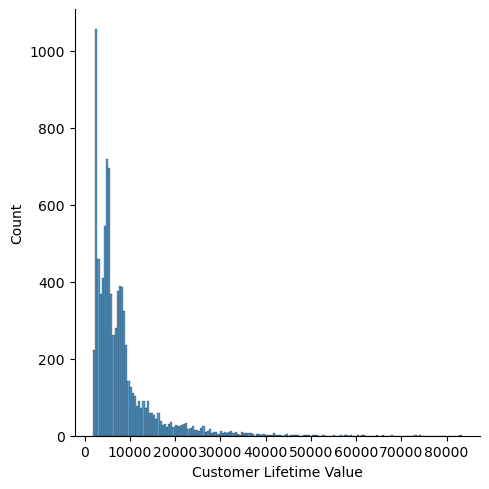

In [35]:
sns.displot(data=df_clv, x='Customer Lifetime Value');

Los valores extremos no son errores. Sin embargo, la diferencia con la mayoría de valores es tan grande, que conviene no incluirlos en el modelo. Por tanto, se van a considerar los clientes con un **CLV < 25000**

Creamos los conjuntos de entrenamiento y test:

In [41]:
from sklearn.model_selection import train_test_split

num_df_cols.remove('Customer Lifetime Value')
X = df_clv[df_clv['Customer Lifetime Value']<25000].drop('Customer Lifetime Value', axis=1)
y = df_clv.loc[df_clv['Customer Lifetime Value']<25000,'Customer Lifetime Value']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

Para llevar a cabo la transformación se utilizará el mismo procedimiento que en la tarea anterior (recuperamos los transformadores creados anteriormente)

In [46]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

num_transformer = 	Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

cat_transformer = 	Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant',fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

In [51]:
from sklearn.compose import ColumnTransformer

clv_trans = ColumnTransformer(transformers=[
    ('num', num_transformer, num_df_cols),
    ('cat', cat_transformer, dis_df_cols)])

## 2.1. Regresión Lineal

Con respecto a la predicción, vamos a utilizar inicialmente un modelo de regresión lineal.

In [56]:
from sklearn.linear_model import LinearRegression

linr_model = LinearRegression();

churn_pipe_linr =  Pipeline(steps=[
    ('trans',clv_trans),
    ('mod', linr_model)])

churn_pipe_linr.fit(X_train, y_train);

print("Entrenamiento:", churn_pipe_linr.score(X_train, y_train))
print("Test:", churn_pipe_linr.score(X_test, y_test))

Entrenamiento: 0.16029168651979941
Test: 0.1686154919582461


El R-cuadrado en este caso es bastante bajo, solo un 16% aproximadamente

Con la siguiente función, se muestra el error absoluto medio con respecto a los datos de entrenamiento y test, y también una medida del error relativo absoluto medio

In [60]:
from sklearn.metrics import mean_absolute_error

def show_errors(y, y_pred):
    mae = mean_absolute_error(y, y_pred)
    rmae = np.sum(np.abs(y-y_pred)/y)/len(y)    
    print(f'\tEl error absoluto medio es: {mae:.2f}')
    print(f'\tEl error absoluto relativo medio es: {rmae:.2f}')

print('Entrenamiento')
y_pred = churn_pipe_linr.predict(X_train)
show_errors(y_train, y_pred)

print('Test')
y_pred = churn_pipe_linr.predict(X_test)
show_errors(y_test, y_pred)

Entrenamiento
	El error absoluto medio es: 2877.94
	El error absoluto relativo medio es: 0.49
Test
	El error absoluto medio es: 2941.74
	El error absoluto relativo medio es: 0.50


## 2.2. Árbol de regresión

Puede apreciarse que el error es muy alto. Por tanto vamos a probar a definir el procedimiento anterior, pero con un árbol de regresión.

In [63]:
from sklearn.tree import DecisionTreeRegressor


dtr_model = DecisionTreeRegressor(random_state=0);

churn_pipe_dtr = Pipeline(steps=[
    ('trans',clv_trans),
    ('mod',dtr_model)])

churn_pipe_dtr.fit(X_train, y_train);

print("Entrenamiento:", churn_pipe_dtr.score(X_train,y_train))
print("Test:", churn_pipe_dtr.score(X_test,y_test))

Entrenamiento: 1.0
Test: 0.6881125590924914


Mostramos de nuevo el error absoluto medio (también el relativo) para entrenamiento y test: 

In [66]:
print('Entrenamiento')
y_pred = churn_pipe_dtr.predict(X_train)
show_errors(y_train, y_pred)

print('Test')
y_pred = churn_pipe_dtr.predict(X_test)
show_errors(y_test, y_pred)

Entrenamiento
	El error absoluto medio es: 0.00
	El error absoluto relativo medio es: 0.00
Test
	El error absoluto medio es: 849.72
	El error absoluto relativo medio es: 0.08


Podemos ver también tamaño del árbol obtenido:

In [71]:
print(f"Profundidad: {churn_pipe_dtr.named_steps['mod'].get_depth()}")
print(f"Número de hojas: {churn_pipe_dtr.named_steps['mod'].get_n_leaves()}")

Profundidad: 30
Número de hojas: 5370


Como se puede observar, el tamaño del árbol es bastante profundo, esto puede dar lugar a sobreajuste. Por tanto, vamos a determinar el número adecuado de capas y hojas para mejorar el resultado:

In [81]:
from sklearn.model_selection import GridSearchCV

params = {}
params['clas__max_depth'] = [None, 2, 5, 10, 15, 20]

dtr_p_model = DecisionTreeRegressor(random_state=0);

churn_pipe_dtr_p = Pipeline(steps=[('prep', clv_trans),
                                   ('clas', dtr_p_model)])

GS_p = GridSearchCV(
    estimator = churn_pipe_dtr_p,
    param_grid = params,
    cv = 5,
    scoring = 'neg_mean_absolute_error',
    n_jobs = -1
)

GS_p.fit(X_train, y_train)
    
print("Mejor score: ", GS_p.best_score_)
print("Mejore configuración de parámetros: ", GS_p.best_params_)

churn_pipe_dtr_p = GS_p.best_estimator_

print("\nEntrenamiento:", churn_pipe_dtr_p.score(X_train, y_train))
print("Test:", churn_pipe_dtr_p.score(X_test, y_test))

Mejor score:  -917.3477327967382
Mejore configuración de parámetros:  {'clas__max_depth': 10}

Entrenamiento: 0.8573322291448411
Test: 0.7665782235886824


Comprobamos de nuevo el tamaño del árbol obtenido:

In [84]:
print(f"Profundidad: {churn_pipe_dtr_p.named_steps['clas'].get_depth()}")
print(f"Número de hojas: {churn_pipe_dtr_p.named_steps['clas'].get_n_leaves()}")

Profundidad: 10
Número de hojas: 710


Como se puede observar, hemos corregido el sobreajuste.

Podemos de nuevo, mostramos el Error absoluto medio (también el relativo) para entrenamiento y test: 

In [88]:
print('Entrenamiento')
y_pred = churn_pipe_dtr_p.predict(X_train)
show_errors(y_train, y_pred)

print('Test')
y_pred = churn_pipe_dtr_p.predict(X_test)
show_errors(y_test, y_pred)

Entrenamiento
	El error absoluto medio es: 607.95
	El error absoluto relativo medio es: 0.06
Test
	El error absoluto medio es: 822.29
	El error absoluto relativo medio es: 0.08


<div><font size=3 color=#00586D> <i class="fa fa-check-square-o" aria-hidden="true"></i></font></div>

<!--comment -->

#### <font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 32</font>


Compara y analiza los resultados obtenidos con respecto a los obtenidos anteriormente.

___Respuesta:___

Esta forma es mucho más efectiva puesto que el árbol ha pasado de tener 30 hojas, o dicho de otra forma una profundidad de 30, a tan solo una de 10. Los errores absolutos medios son bastante similares

<div><font size=3 color=#00586D> <i class="fa fa-check-square-o" aria-hidden="true"></i></font></div>

<!--comment -->

# 3. Segmentación de clientes

En el manejo de la relación con el cliente es necesario tener en cuenta varios factores. Cada cliente tiene unas peculiaridades, y la relación con él se ha de definir de manera concreta. Debido a esto, la segmentación es clave, cuyo objetivo es crear grupos de clientes con el mismo perfil.

Partimos de un conjunto de datos obtenido también del sitio de IBM analytics. Vamos a proceder a cargar los datos:

In [49]:
df_seg = pd.read_csv('data/segmentation/online12M.csv', index_col=0, parse_dates=['InvoiceDate']);

df_seg.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
416792,572558,22745,POPPY'S PLAYHOUSE BEDROOM,6,2011-10-25,2.10,14286,United Kingdom
482904,577485,23196,VINTAGE LEAF MAGNETIC NOTEPAD,1,2011-11-20,1.45,16360,United Kingdom
263743,560034,23299,FOOD COVER WITH BEADS SET 2,6,2011-07-14,3.75,13933,United Kingdom
495549,578307,72349B,SET/6 PURPLE BUTTERFLY T-LIGHTS,1,2011-11-23,2.10,17290,United Kingdom
204384,554656,21756,BATH BUILDING BLOCK WORD,3,2011-05-25,5.95,17663,United Kingdom


El análisis RFM (Recencia, Frecuencia, Valor Monetario) es una metodología de segmentación basada en el comportamiento pasado de los clientes. 

A continuación voy a proceder a crear las columnas 'Recencia', 'Frecuencia' y 'ValorMonetario':


* **Recencia**: creamos un día de referencia (el posterior al último de la lista) y le restamos el último día en que compró cada cliente
* **Frecuencia**: contamos el número de facturas
* **ValorMonetario**: sumamos para cada cliente su gasto efectuado. Previamente se creará una columna con el gasto

In [52]:
import datetime
dia_ref = max(df_seg['InvoiceDate']) + datetime.timedelta(days=1)

df_seg['Total'] = df_seg['Quantity']*df_seg['UnitPrice']

df_rfm = df_seg.groupby(['CustomerID']).agg({ 
    'InvoiceDate': lambda x: (dia_ref - x.max()).days, 
    'InvoiceNo': 'count',
    'Total': 'sum'})

df_rfm.rename(columns = {'InvoiceDate': 'Recencia', 'InvoiceNo': 'Frecuencia', 'Total': 'ValorMonetario'}, inplace=True)

df_rfm.head()

,Recencia,Frecuencia,ValorMonetario
CustomerID,,,
12747,3,25,948.70
12748,1,888,7046.16
12749,4,37,813.45
12820,4,17,268.02
12822,71,9,146.15


Vamos a comprobar la distribución de cada una de las variables:

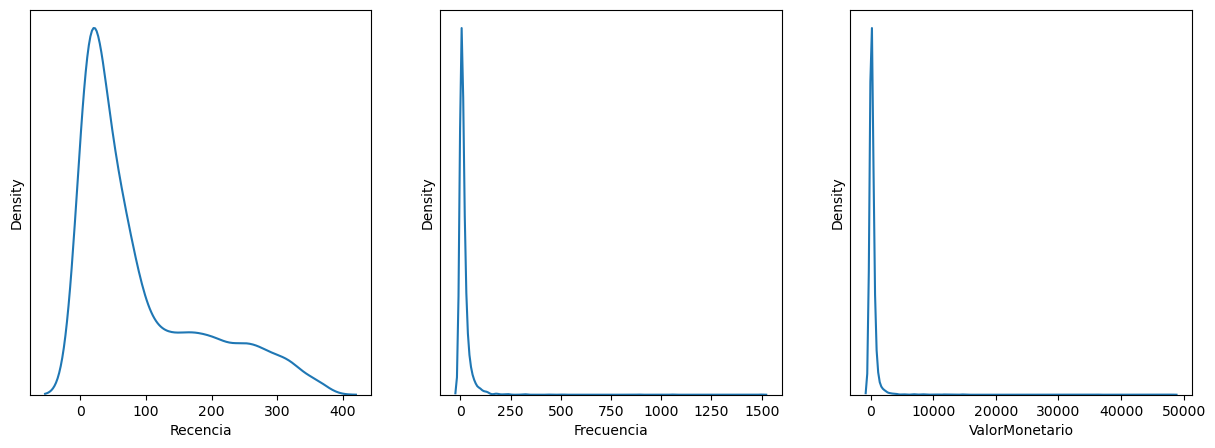

In [55]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
campos = ['Recencia', 'Frecuencia','ValorMonetario']
for col, ax in enumerate(axs.flatten()):
    col_name = campos[col]
    sns.kdeplot(data=df_rfm, x=col_name, ax=ax) 
    ax.set_yticks([])

Puede apreciarse que las distribuciones están muy sesgadas. Una forma de solucionarlo es utilizar el logaritmo de las variables:

La diferencia de escalas también supone un problema, ya que hace que el cálculo de las distancias de más importancia a las variables con mayor rango. Por ello, vamos también a estandarizar los datos:

In [58]:
#Logaritmo de las variables
df_rfm_log = np.log(df_rfm)

In [60]:
#Estandarizar
df_rfm_norm = df_rfm_log - df_rfm_log.mean()
df_rfm_norm = df_rfm_norm / df_rfm_log.std()
df_rfm_norm.describe()

,Recencia,Frecuencia,ValorMonetario
count,3.643000e+03,3.643000e+03,3.643000e+03
mean,-5.900060e-17,2.252750e-16,3.588797e-16
std,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.814131e+00,-1.794485e+00,-4.092988e+00
25%,-6.373074e-01,-6.490904e-01,-6.578277e-01
50%,9.266763e-02,2.092218e-02,-1.489601e-02
75%,8.339256e-01,7.209827e-01,6.692029e-01
max,1.547663e+00,4.246243e+00,4.458854e+00


Una vez preparados los datos, vamos a llevar a cabo el procedimiento de agrupación. Ejecutamos 'KMeans' para valores del 1 al 15, almacenando el coste resultante para cada valor de k

In [63]:
from sklearn.cluster import KMeans

cost = {}
for k in range(1, 15):
    kmeans = KMeans(k)
    kmeans.fit(df_rfm_norm)
    cost[k] = kmeans.inertia_

Dibujamos ahora la función de coste

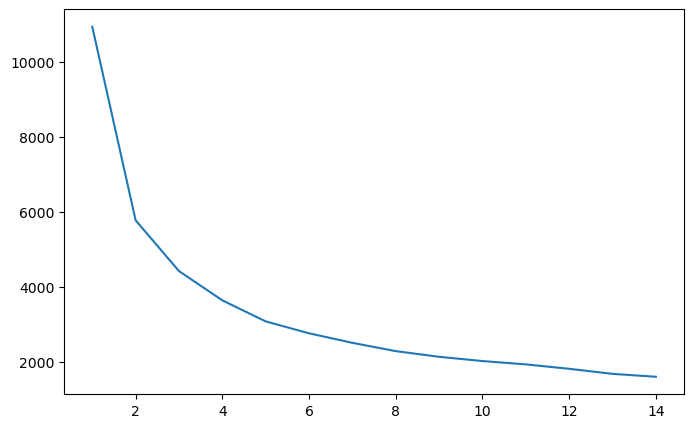

In [66]:
plt.figure(figsize=(8, 5))
plt.plot(cost.keys(), cost.values())
plt.show()

Podemos observar que a partir de k=4 el descenso se estabiliza. Por ello, realizamos el agrupamiento con k=4

In [69]:
kmeans = KMeans(4)
kmeans.fit(df_rfm_norm)
results = kmeans.inertia_

results

3641.530401116521

Añadimos a cada entrada de df_rfm la etiqueta correspondiente al cluster:

In [72]:
df_rfm = df_rfm.assign(Group = kmeans.labels_)
df_rfm.head()

,Recencia,Frecuencia,ValorMonetario,Group
CustomerID,,,,
12747,3,25,948.70,1
12748,1,888,7046.16,1
12749,4,37,813.45,1
12820,4,17,268.02,1
12822,71,9,146.15,0


Un modo sencillo de visualizar la importancia relativa de cada variable en cada grupo es dividiendo los valores medios de cada grupo por las medias de cada columna para el total de la información.

In [77]:
df_clusters_mean = df_rfm.groupby('Group')[['Recencia','Frecuencia','ValorMonetario']].mean()
means = df_rfm[['Recencia','Frecuencia','ValorMonetario']].mean()

relative_imp = (df_clusters_mean/means)-1
relative_imp

,Recencia,Frecuencia,ValorMonetario
Group,,,
0,0.435348,-0.371267,-0.375417
1,-0.784099,1.869842,2.046491
2,-0.783257,-0.446078,-0.607671
3,0.828383,-0.861159,-0.880952


Vamos a dibujar un mapa de calor con los datos de la importancia relativa:

In [83]:
relative_imp['Recencia'] = -1 * relative_imp['Recencia'] # Transformamos esta variable puesto que en el caso de la frecuencia y valor monetario más es mejor, y en la recencia es al revés. Por lo que de esta forma se entiende mejor el mapa

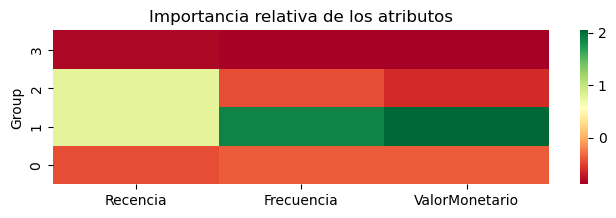

In [85]:
plt.figure(figsize=(8, 2))
plt.title('Importancia relativa de los atributos')
sns.heatmap(relative_imp,
           fmt='.2f',
           cmap='RdYlGn')
plt.gca().set_ylim(0,4);

## 3.1. Conclusiones

Grupo 0: clientes de bajo valor

Grupo 1: grupo de clientes clave, ya que son aquellos cuyo gasto es mayor a la par que su frecuencia de compra

Grupo 2: clientes que son más recientes, las nuevas promociones pueden calar bien en ellos

Grupo 3: clientes de bajo valor

**Deberíamos orientar nuestras campañas de marketing sobre todo centrados en el grupo 1, que son aquellos clientes que nos serán más rentables**